<a href="https://colab.research.google.com/github/sreehari59/Polar-Embedding/blob/main/PolarWebE_and_Hofstede.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
from operator import index
from pandas.core.frame import DataFrame
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

from random import shuffle

import plotly.graph_objs as go

import plotly
import colorlover as cl
import plotly.offline as py
import plotly.graph_objs as go

import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import mean_absolute_error,mean_squared_error

import matplotlib.pyplot as plt

**Choose the required options from the below cell and the results can been seen at the end of the notebook**

In [194]:
from re import S
print("Please choose any of the Pretrained Model")
print("1. Glove Wiki")
print("2. Google News")
pretrained_model = input("Enter the Pretrained Model: ")

print("\nPlease choose any to see performance of Polar embedding --> Hofstede")
print("1. Average Performance of the model over all the Hofstede's dimension")
print("2. Performance of the model over a single Hofstede Dimension")
polar_evaluation = input("Enter the option: ")

if polar_evaluation in "2. Individual Performance of the model":
  
  print("\nPlease choose any of the Hofstede dimension")
  print("1. Power Distance")
  print("2. Individualism vs Collectivism")
  print("3. Masculinity vs Femininity")
  print("4. Long Term vs Short Term Orientation")
  print("5. Indulgence vs Restraint")
  print("6. Uncertainty Avoidance\n")

  Hofstede_dimensions = input("Enter the Hofstede Dimension: ")

Please choose any of the Pretrained Model
1. Glove Wiki
2. Google News
Enter the Pretrained Model: 2

Please choose any to see performance of Polar embedding --> Hofstede
1. Average Performance of the model over all the Hofstede's dimension
2. Performance of the model over a single Hofstede Dimension
Enter the option: 2

Please choose any of the Hofstede dimension
1. Power Distance
2. Individualism vs Collectivism
3. Masculinity vs Femininity
4. Long Term vs Short Term Orientation
5. Indulgence vs Restraint
6. Uncertainty Avoidance

Enter the Hofstede Dimension: 4


In [195]:
avgrank_random_list=[]
avgrank_nearest_random_list=[]
avgrank_human_list=[]
avgrank_nearest_human_list=[]

avgscore_random_list = []
avgscore_nearest_random_list = []
avgscore_human_list = []
avgscore_nearest_human_list = []

MAE_random = []
correlation_rank_random = []
rmse_random = []

MAE_human = []
correlation_rank_human = []
rmse_human = []

In [196]:
avg_corr_rank_random_list = []
avg_corr_rank_nearest_random_list = []
avg_corr_rank_human_list = []
avg_corr_rank_nearest_human_list = []

avg_corr_score_random_list = []
avg_corr_score_nearest_random_list = []
avg_corr_score_human_list = []
avg_corr_score_nearest_human_list = []

In [197]:
def list_avg(avg_list):
  sum = 0
  for i in avg_list:
    sum = sum + i
  return sum/len(avg_list)

In [198]:
def polar_list(list):
  
  right_polar_list = []
  left_polar_list = []
  for i in range(0,len(list)):
    
    left_polar_list.append(list[i][0].replace("-","_"))
    right_polar_list.append(list[i][1].replace("-","_"))

  return left_polar_list,right_polar_list


def alphabetical_list_creation(list):
  new_list = []
  
  for i in range(0,len(list)):
    index_0 = list[i][0].replace("-","_")
    index_1 = list[i][1].replace("-","_")
    
    if index_0 < index_1:
      val = index_0+"-"+index_1
      new_list.append(val)
      
    else:
      val = index_1+"-"+index_0
      new_list.append(val)
      
  return new_list

def company_count(company_df,input_list,polar_embedding):  

  # we then find the number of companies grouped on the basis of location
  for i in input_list:       
    j = i.replace("-","")    
    j = j.replace("_","-")
    
    subset_df2 = polar_embedding[polar_embedding[j] < 0]
    company_inclined_to_left_polar_df1 = subset_df2['Location'].value_counts()
    left_polar = i.split("-")[0]
    
    company_inclined_to_left_polar_df1 = pd.DataFrame({'Country':company_inclined_to_left_polar_df1.index, left_polar :company_inclined_to_left_polar_df1.values})
    company_df=pd.merge(company_df, company_inclined_to_left_polar_df1, how='left',on='Country')    
    company_df[left_polar] = round( company_df[left_polar] / company_df.iloc[:,1] * 100)

    subset_df1 = polar_embedding[polar_embedding[j] > 0]
    company_inclined_to_right_polar_df1 = subset_df1['Location'].value_counts()
    right_polar = i.split("-")[1]
    
    company_inclined_to_right_polar_df1 = pd.DataFrame({'Country':company_inclined_to_right_polar_df1.index, right_polar :company_inclined_to_right_polar_df1.values})
    company_df=pd.merge(company_df, company_inclined_to_right_polar_df1, how='left',on='Country')    
    company_df[right_polar] = round( company_df[right_polar] / company_df.iloc[:,1] * 100)


  company_df = company_df.fillna(0)

  # We are considering only the countries if the numberof companies in the country is over 3
  company_df = company_df[company_df['Total Count'] > 3]

  return company_df


def polar_ranking(polar_list,total_score,ranking,company_df):
  total_sum=0
  total_sum_list=[]
  polar_ranking_list = []
  polar_index=0
  for index,row in company_df.iterrows():  
    
    for i in polar_list:
      
      total_sum = total_sum + (row[i])
    #print(company_df.iloc[index,2:])  
    total_sum_list.append(total_sum/len(polar_list))
    polar_ranking_list.append(index+1)
    total_sum = 0

  company_df[total_score] = total_sum_list
  company_df= company_df.sort_values(by=[total_score],ascending=False)
  company_df[ranking] = polar_ranking_list

  return company_df

def normalize(x):
  return (x-np.min(x)) / (np.max(x) - np.min(x))

# Mean absolute error of the score
def mean_absolute_error_score(merged_df,dimension):
  MAE_of_Score = []
  MAE_of_Score.append(mean_absolute_error(merged_df[dimension], merged_df["Total Score Random"]))
  MAE_of_Score.append(mean_absolute_error(merged_df[dimension], merged_df["Total Score Nearest Random"]))
  MAE_of_Score.append(mean_absolute_error(merged_df[dimension], merged_df["Total Score Human"]))
  MAE_of_Score.append(mean_absolute_error(merged_df[dimension], merged_df["Total Score Nearest Human"]))
  return MAE_of_Score

# Mean absolute error of the rank
def mean_absolute_error_rank(merged_df,dimension_ranking):
  MAE = []
  MAE.append(mean_absolute_error(merged_df[dimension_ranking], merged_df["Polar Rank R"]))
  MAE.append(mean_absolute_error(merged_df[dimension_ranking], merged_df["Polar Rank Nearest R"]))
  MAE.append(mean_absolute_error(merged_df[dimension_ranking], merged_df["Polar Rank H"]))
  MAE.append(mean_absolute_error(merged_df[dimension_ranking], merged_df["Polar Rank Nearest H"]))
  return MAE

# Root Mean squared error of the score
def root_mean_squared_error_score(merged_df,dimension):
  RMSE_of_Score = []
  RMSE_of_Score.append(np.sqrt(mean_squared_error(merged_df[dimension], merged_df["Total Score Random"])))
  RMSE_of_Score.append(np.sqrt(mean_squared_error(merged_df[dimension], merged_df["Total Score Nearest Random"])))
  RMSE_of_Score.append(np.sqrt(mean_squared_error(merged_df[dimension], merged_df["Total Score Human"])))
  RMSE_of_Score.append(np.sqrt(mean_squared_error(merged_df[dimension], merged_df["Total Score Nearest Human"])))
  return RMSE_of_Score

# Root Mean squarred error of the rank
def root_mean_squared_error_rank(merged_df,dimension_ranking):
  RMSE = []
  RMSE.append(np.sqrt(mean_squared_error(merged_df[dimension_ranking], merged_df["Polar Rank R"])))
  RMSE.append(np.sqrt(mean_squared_error(merged_df[dimension_ranking], merged_df["Polar Rank Nearest R"])))
  RMSE.append(np.sqrt(mean_squared_error(merged_df[dimension_ranking], merged_df["Polar Rank H"])))
  RMSE.append(np.sqrt(mean_squared_error(merged_df[dimension_ranking], merged_df["Polar Rank Nearest H"])))
  return RMSE

# Normalized Root Mean squarred error of the score
def normalized_root_mean_squared_error_score(merged_df,dimension):
  N_RMSE = []
  N_RMSE.append(np.sqrt(mean_squared_error(normalize(merged_df[dimension].astype(int)), normalize(merged_df["Total Score Random"]))))
  N_RMSE.append(np.sqrt(mean_squared_error(normalize(merged_df[dimension].astype(int)), normalize(merged_df["Total Score Nearest Random"]))))
  N_RMSE.append(np.sqrt(mean_squared_error(normalize(merged_df[dimension].astype(int)), normalize(merged_df["Total Score Human"]))))
  N_RMSE.append(np.sqrt(mean_squared_error(normalize(merged_df[dimension].astype(int)), normalize(merged_df["Total Score Nearest Human"]))))
  return N_RMSE

def correlation_calc(merged_df,dimension_ranking):
  correlation = []
  correlation.append(merged_df["Polar Rank R"].corr(merged_df[dimension_ranking]))
  correlation.append(merged_df["Polar Rank Nearest R"].corr(merged_df[dimension_ranking]))
  correlation.append(merged_df["Polar Rank H"].corr(merged_df[dimension_ranking]))
  correlation.append(merged_df["Polar Rank Nearest H"].corr(merged_df[dimension_ranking]))
  return correlation

def correlation_calc_score(merged_df,dimension):
  correlation = []
  correlation.append(merged_df["Total Score Random"].corr(merged_df[dimension].astype(int)))
  correlation.append(merged_df["Total Score Nearest Random"].corr(merged_df[dimension].astype(int)))
  correlation.append(merged_df["Total Score Human"].corr(merged_df[dimension].astype(int)))
  correlation.append(merged_df["Total Score Nearest Human"].corr(merged_df[dimension].astype(int)))
  return correlation  

**Below cell choose the polar embedding and lists for respective Pretrained model**

In [199]:
if pretrained_model in "1. Glove Wiki": 

  new_df = pd.read_csv('/content/drive/MyDrive/Polar Embedding/120 dimension polar embedding.csv')

  # Power Distance (High Power Distance, Low Power Distance)
  list_powerdistance_random =[('make', 'break'), ('cameraman', 'playwright'), ('mystical', 'factual'), ('promotional', 'defamation'), ('iconic', 'unknown')]
  nearest_random_list_powerdistance =[('making', 'breaking'), ('cameramen', 'dramatist'), ('magical', 'inaccuracies'), ('promo', 'libel'), ('recognizable', 'undetermined')]
  list_powerdistance =[('hierarchical','non-hierarchical'),('superior','equal'),('leader','subordinate'),('inequality','equality'),('autocrat','democrat')]
  nearest_human_list_powerdistance = [('hierarchy', 'consensus-based'), ('inferior', 'equalitys'), ('leaders', 'subordinates'), ('inequalities', 'equals'), ('autocratic', 'senator')]

  # Individualism (Individualism, Collectivism)
  list_individualism_random = [('lop', 'secure'), ('shah', 'poor'), ('pneumatic', 'solid'), ('interpret', 'misinterpret'), ('confer', 'refuse')]
  nearest_random_list_individualism= [('buri', 'securing'), ('ahmad', 'poorer'), ('hydraulic', 'consistent'), ('interpreting', 'misunderstand'), ('conferring', 'refusing')]
  list_individualism = [('individuality','community'),('self-interest','harmony'),('tasks','relationships'),('individual','groups'),('universalism','particularism')]
  nearest_human_list_individualism = [('originality', 'communities'), ('selfishness', 'harmonious'), ('task', 'relationship'), ('individuals', 'group'), ('mangxamba', 'unitarianism')]

  # Masculinity
  list_masculinity_random = [('try', 'abstain'), ('fatalistic', 'freewill'), ('knowledgeable', 'uninformed'), ('confine', 'free'), ('fan', 'warm')]
  nearest_random_list_masculinity = [('trying', 'abstaining'), ('nonchalant', 'gmv'), ('knowledgable', 'misinformed'), ('confining', 'freedom'), ('fans', 'cool')]
  list_masculinity = [('achievement', 'support'),('competitive', 'caring'),('assertive', 'submissive'),('ambitious', 'unambitious'),('sucess','cooperation')]
  nearest_human_list_masculinity = [('achievements', 'supported'), ('competition', 'loving'), ('forceful', 'subservient'), ('undertaking', 'unathletic'), ('ufauthor', 'bilateral')]

  # long term Orientation
  list_longterm_random = [('innovator', 'follower'), ('sensory', 'numb'), ('hedge', 'squander'), ('arachnid', 'serpent'), ('disclose', 'secrete')]
  nearest_random_list_longterm = [('visionary', 'disciple'), ('auditory', 'numbed'), ('fund', 'squandering'), ('itsy', 'serpents'), ('disclosing', 'secreted')]
  list_longterm = [('pragmatic','normative'),('progress','preserve'),('adapt','conserve'),('developing','stable'),('advance','retain')]
  nearest_human_list_longterm = [('pragmatism', 'conceptions'), ('efforts', 'preserving'), ('adapting', 'conserving'), ('develop', 'stability'), ('advancing', 'retained')]

  # Indulgence
  list_indulgence_random = [('diagnose', 'sicken'), ('intercourse', 'disconnection'), ('sensory', 'sensorial'), ('emasculate', 'strengthen'), ('metropolitan', 'rural')]
  nearest_random_list_indulgence = [('diagnosing', 'sickens'), ('sexual', 'disconnect'), ('auditory', 'skorokhod'), ('disempower', 'strengthening'), ('metro', 'urban')]
  list_indulgence = [('fulfillment','restriction'),('satisfaction','limitation'),('liberty','moderation'),('expand','direct'),('freedom','regulation')]
  nearest_human_list_indulgence = [('fulfilment', 'restrictions'), ('satisfied', 'limitations'), ('fredom', 'restraint'), ('expanding', 'indirect'), ('freedoms', 'regulations')]

  # Unceratinity Avoidance
  list_uncertainity_avoidance_random = [('stretcher', 'compressor'), ('amalgamate', 'separate'), ('caretaker', 'assailant'), ('taker', 'violator'), ('contaminate', 'sterilize')]
  nearest_random_list_uncertainity_avoidance = [('stretchers', 'compressors'), ('amalgamating', 'separately'), ('interim', 'assailants'), ('takers', 'violators'), ('contaminating', 'sterilized')]
  list_uncertainity_avoidance = [('clarity','complexity'),('clear','ambiguous'),('certain','uncertain'),('uniformity','diversity'),('agreement','variation')]
  nearest_human_list_uncertainity_avoidance = [('simplicity', 'complexities'), ('yet', 'vague'), ('particular', 'unclear'), ('homogeneity', 'diverse'), ('agreements', 'variations')]

else:

  new_df = pd.read_csv('/content/drive/MyDrive/Polar Embedding/polar_embedding_gnews.csv')
  new_df['Unnamed: 0'] = new_df['Unnamed: 0'].str.lower()
  new_df['Unnamed: 0'] = new_df['Unnamed: 0'].str.replace("_","")

  # Power Distance (High Power Distance, Low Power Distance)
  list_powerdistance_random =[('make', 'break'), ('cameraman', 'playwright'), ('mystical', 'factual'), ('promotional', 'defamation'), ('iconic', 'unknown')]
  nearest_random_list_powerdistance = [('making', 'breaks'), ('camerman', 'dramatist'), ('mystic', 'facts'), ('Promotional', 'libel'), ('Iconic', 'unkown')]
  list_powerdistance =[('hierarchical','nonhierarchical'),('superior','equal'),('leader','subordinate'),('inequality','equality'),('autocrat','democrat')]
  nearest_human_list_powerdistance = [('hierarchal', 'rigidhierarchical'), ('inferior', 'Equal'), ('leadership', 'subordinates'), ('inequalities', 'genderequality'), ('despot', 'democrats')]

  # Individualism (Individualism, Collectivism)
  list_individualism_random = [('lop', 'secure'), ('shah', 'poor'), ('pneumatic', 'solid'), ('interpret', 'misinterpret'), ('confer', 'refuse')]
  nearest_random_list_individualism = [('lopped', 'securing'), ('Pahlavi', 'poorer'), ('hydraulic', 'strong'), ('interpreting', 'misunderstand'), ('conferred', 'refusing')]
  list_individualism = [('individuality','community'),('egotism','harmony'),('tasks','relationships'),('individual','groups'),('particularism','universalism')]
  nearest_human_list_individualism = [('individualism', 'communities'), ('narcissism', 'harmonious'), ('mundanetasks', 'relationship'), ('individually', 'Groups'), ('exclusivism', 'universalist')]

  # Masculinity
  list_masculinity_random = [('try', 'abstain'), ('fatalistic', 'freewill'), ('knowledgeable', 'uninformed'), ('confine', 'free'), ('fan', 'warm')]
  nearest_random_list_masculinity = [('trying', 'abstaining'), ('fatalist', 'eternaldestiny'), ('knowledgable', 'ignorant'), ('confining', 'Free'), ('fans', 'Warm')]
  list_masculinity = [('achievement', 'support'),('competitive', 'caring'),('assertive', 'submissive'),('ambitious', 'unambitious'),('sucess','cooperation')]
  nearest_human_list_masculinity = [('acheivement', 'supporting'), ('competitve', 'compassionate'), ('assertiveness', 'subservient'), ('Ambitious', 'unimaginative'), ('success', 'bilateralcooperation')]

  # long term Orientation
  list_longterm_random = [('innovator', 'follower'), ('sensory', 'numb'), ('hedge', 'squander'), ('arachnid', 'serpent'), ('disclose', 'secrete')]
  nearest_random_list_longterm = [('pioneer', 'devotee'), ('auditory', 'numbed'), ('hedges', 'squandered'), ('spider', 'serpents'), ('divulge', 'secretes')]
  list_longterm = [('pragmatic','normative'),('progress','preserve'),('adapt','conserve'),('developing','stable'),('advance','retain')]
  nearest_human_list_longterm = [('pragmatism', 'deontological'), ('progess', 'preserving'), ('adapting', 'conserving'), ('develop', 'stabile'), ('advancing', 'retaining')]

  # Indulgence
  list_indulgence_random = [('diagnose', 'sicken'), ('intercourse', 'disconnection'), ('sensorys', 'sensorial'), ('emasculate', 'strengthen'), ('metropolitan', 'rural')]
  nearest_random_list_indulgence = [('accuratelydiagnose', 'sickens'), ('sexualintercourse', 'disconnections'), ('auditory', 'sensory'), ('eviscerate', 'strengthening'), ('metro', 'Rural')]
  list_indulgence = [('fulfillment','restriction'),('satisfaction','limitation'),('liberty','moderation'),('expand','direct'),('freedom','regulation')]
  nearest_human_list_indulgence = [('fulfillments', 'restrictions'), ('Satisfaction', 'limitations'), ('fredom', 'Moderation'), ('broaden', 'indirect'), ('freedoms', 'regulations')]

  # Unceratinity Avoidance
  list_uncertainity_avoidance_random = [('stretcher', 'compressor'), ('amalgamate', 'separate'), ('caretaker', 'assailant'), ('taker', 'violator'), ('contaminate', 'sterilize')]
  nearest_random_list_uncertainity_avoidance = [('stretchers', 'compressors'), ('merge', 'seperate'), ('Caretaker', 'assailants'), ('takers', 'violators'), ('contaminating', 'sterilized')]
  list_uncertainity_avoidance = [('clarity','complexity'),('clear','ambiguous'),('certain','uncertain'),('uniformity','diversity'),('agreement','variation')]
  nearest_human_list_uncertainity_avoidance = [('coherence', 'complexities'), ('crystalclear', 'vague'), ('these', 'unsure'), ('homogeneity', 'culturaldiversity'), ('agreements', 'variations')]


Below cell loads all the required CSV files like the Fortune 500 comapnies and Hofstede's cultural dimensions

In [200]:
# Loads the Fortune 500 comapnies
fortune_500_company = pd.read_csv('/content/drive/MyDrive/Fortune Global 500 companies.csv',encoding= 'unicode_escape')
fortune_500_company['Company'] = fortune_500_company['Company'].str.lower()
fortune_500_company['Company'] = fortune_500_company['Company'].str.replace(" ", "")

polar_embedding = pd.merge(fortune_500_company, new_df, how="right", left_on="Company", right_on="Unnamed: 0")

polar_embedding = polar_embedding.drop(['Rank'], axis=1)  # This will drop the column Rank
polar_embedding = polar_embedding.drop(['Unnamed: 0'], axis=1)  # This will drop the column Rank

# This will find the total number of companies in our data frame based on Location
total_company_list_based_on_loc = polar_embedding['Location'].value_counts()
total_company_count_df = pd.DataFrame({'Country': total_company_list_based_on_loc.index, 'Total Count': total_company_list_based_on_loc.values})

# This will load the Hofstede 6 Dimension dataset
hofstede_df = pd.read_csv("/content/drive/MyDrive/Polar Embedding/Hofstede 6 dimensions.csv",sep=";")
hofstede_df=hofstede_df[hofstede_df.iloc[:,:]!="#NULL!" ]



Plot for the Correlation between ranking based on Hofstede Score and ranks of our 4 lists


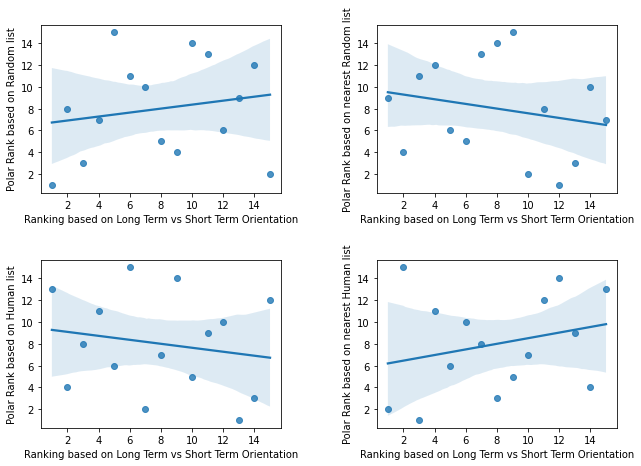



Plot for the Hofstede dimension score and our score we got for each of the 4 list




Comparison Between the 4 list and  Long Term vs Short Term Orientation


,Mean Absolute Error of Rank,Correlation between rank,RMSE of Score,Correlation between score
Random List,4.400000,0.182143,34.937659,0.501556
Nearest Random List,6.000000,-0.214286,28.848431,0.638605
Human Made List,5.466667,-0.182143,24.122355,0.175427
Nearest to Human Made List,4.000000,0.257143,29.258526,-0.166290




Comparison Between Random list to Nearest to Random list


,Mean Absolute Error of Rank,Correlation,RMSE of Score
Random List,6.533333,-0.35,9.782297




Comparison Between Human list to nearest to Human list


,Mean Absolute Error of Rank,Correlation,RMSE of Score
Human Made List,4.8,0.028571,9.674571





Correaltion Heat Map


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:249: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,Total Count,Total Score Random,Polar Rank R,Total Score Nearest Random,Polar Rank Nearest R,Total Score Human,Polar Rank H,Total Score Nearest Human,Polar Rank Nearest H,Long term orientation Ranking
Total Count,1.00,-0.26,0.22,-0.25,0.11,-0.11,-0.40,-0.26,-0.13,0.14
Total Score Random,-0.26,1.00,-0.97,0.75,0.35,-0.12,0.53,-0.10,-0.30,-0.26
Polar Rank R,0.22,-0.97,1.00,-0.73,-0.35,0.19,-0.47,0.17,0.18,0.18
Total Score Nearest Random,-0.25,0.75,-0.73,1.00,0.09,-0.10,0.36,-0.17,-0.07,-0.30
Polar Rank Nearest R,0.11,0.35,-0.35,0.09,1.00,0.43,0.17,0.49,-0.54,-0.21
Total Score Human,-0.11,-0.12,0.19,-0.10,0.43,1.00,0.14,0.52,-0.04,-0.26
Polar Rank H,-0.40,0.53,-0.47,0.36,0.17,0.14,1.00,0.11,0.03,-0.18
Total Score Nearest Human,-0.26,-0.10,0.17,-0.17,0.49,0.52,0.11,1.00,-0.15,-0.21
Polar Rank Nearest H,-0.13,-0.30,0.18,-0.07,-0.54,-0.04,0.03,-0.15,1.00,0.26
Long term orientation Ranking,0.14,-0.26,0.18,-0.30,-0.21,-0.26,-0.18,-0.21,0.26,1.00


In [202]:
hofstede_dimension_list = []
if polar_evaluation in "1. Average Performance of the model over all the Hofstede's dimension" :
  hofstede_dimension_list = ["Power Distance", "Individualism vs Collectivism", "Masculinity vs Femininity", "Long Term vs Short Term Orientation", "Indulgence vs Restraint", "Uncertainty Avoidance" ]
else:
  hofstede_dimension_list.append(Hofstede_dimensions)


for i in hofstede_dimension_list:  

  if i in '1. Power Distance' :
    Hofstede_dimensions = "Power Distance"
    dim_index="Power distance index"
    dimension_ranking="Power distance Ranking"
    
    left_polar_list_random,right_polar_list_random = polar_list(list_powerdistance_random)
    left_polar_list_nearest_random,right_polar_list_nearest_random = polar_list(nearest_random_list_powerdistance)
    left_polar_list_human,right_polar_list_human = polar_list(list_powerdistance)
    left_polar_list_nearest_human,right_polar_list_nearest_human = polar_list(nearest_human_list_powerdistance)


    input_list_random = alphabetical_list_creation(list_powerdistance_random)
    input_list_nearest_random = alphabetical_list_creation(nearest_random_list_powerdistance)
    input_list_human = alphabetical_list_creation(list_powerdistance)
    input_list_nearest_human = alphabetical_list_creation(nearest_human_list_powerdistance)    

  elif i in '2. Individualism vs Collectivism':
    Hofstede_dimensions = "Individualism vs Collectivism"
    dim_index="Individualism index"
    dimension_ranking="Individualism Ranking"
      

    left_polar_list_random,right_polar_list_random = polar_list(list_individualism_random)
    left_polar_list_nearest_random,right_polar_list_nearest_random = polar_list(nearest_random_list_individualism)
    left_polar_list_human,right_polar_list_human = polar_list(list_individualism)
    left_polar_list_nearest_human,right_polar_list_nearest_human = polar_list(nearest_human_list_individualism)


    input_list_random = alphabetical_list_creation(list_individualism_random)
    input_list_nearest_random = alphabetical_list_creation(nearest_random_list_individualism)
    input_list_human = alphabetical_list_creation(list_individualism)
    input_list_nearest_human = alphabetical_list_creation(nearest_human_list_individualism)

  elif i in '3. Masculinity vs Femininity':
    Hofstede_dimensions = "Masculinity vs Femininity"
    dim_index="Masculinity index"
    dimension_ranking="Masculinity Ranking"

    
    left_polar_list_random,right_polar_list_random = polar_list(list_masculinity_random)
    left_polar_list_nearest_random,right_polar_list_nearest_random = polar_list(nearest_random_list_masculinity)
    left_polar_list_human,right_polar_list_human = polar_list(list_masculinity)
    left_polar_list_nearest_human,right_polar_list_nearest_human = polar_list(nearest_human_list_masculinity)


    input_list_random = alphabetical_list_creation(list_masculinity_random)
    input_list_nearest_random = alphabetical_list_creation(nearest_random_list_masculinity)
    input_list_human = alphabetical_list_creation(list_masculinity)
    input_list_nearest_human = alphabetical_list_creation(nearest_human_list_masculinity)
      

  elif i in '4. Long Term vs Short Term Orientation':
    Hofstede_dimensions = "Long Term vs Short Term Orientation"
    dim_index="Long term orientation index"
    dimension_ranking="Long term orientation Ranking"

    
    left_polar_list_random,right_polar_list_random = polar_list(list_longterm_random)
    left_polar_list_nearest_random,right_polar_list_nearest_random = polar_list(nearest_random_list_longterm)
    left_polar_list_human,right_polar_list_human = polar_list(list_longterm)
    left_polar_list_nearest_human,right_polar_list_nearest_human = polar_list(nearest_human_list_longterm)


    input_list_random = alphabetical_list_creation(list_longterm_random)
    input_list_nearest_random = alphabetical_list_creation(nearest_random_list_longterm)
    input_list_human = alphabetical_list_creation(list_longterm)
    input_list_nearest_human = alphabetical_list_creation(nearest_human_list_longterm)
      

  elif i in '5. Indulgence vs Restraint':
    Hofstede_dimensions = "Indulgence vs Restraint"
    dim_index="Indulgence index"
    dimension_ranking="Indulgence Ranking"

    
    left_polar_list_random,right_polar_list_random = polar_list(list_indulgence_random)
    left_polar_list_nearest_random,right_polar_list_nearest_random = polar_list(nearest_random_list_indulgence)
    left_polar_list_human,right_polar_list_human = polar_list(list_indulgence)
    left_polar_list_nearest_human,right_polar_list_nearest_human = polar_list(nearest_human_list_indulgence)


    input_list_random = alphabetical_list_creation(list_indulgence_random)
    input_list_nearest_random = alphabetical_list_creation(nearest_random_list_indulgence)
    input_list_human = alphabetical_list_creation(list_indulgence)
    input_list_nearest_human = alphabetical_list_creation(nearest_human_list_indulgence)
      

  elif i in '6. Uncertainty Avoidance':
    Hofstede_dimensions = "Uncertainty Avoidance"
    dim_index="Uncertainty avoidance index"
    dimension_ranking="Uncertainty avoidance Ranking"

    
    left_polar_list_random,right_polar_list_random = polar_list(list_uncertainity_avoidance_random)
    left_polar_list_nearest_random,right_polar_list_nearest_random = polar_list(nearest_random_list_uncertainity_avoidance)
    left_polar_list_human,right_polar_list_human = polar_list(list_uncertainity_avoidance)
    left_polar_list_nearest_human,right_polar_list_nearest_human = polar_list(nearest_human_list_uncertainity_avoidance)


    input_list_random = alphabetical_list_creation(list_uncertainity_avoidance_random)
    input_list_nearest_random = alphabetical_list_creation(nearest_random_list_uncertainity_avoidance)
    input_list_human = alphabetical_list_creation(list_uncertainity_avoidance)
    input_list_nearest_human = alphabetical_list_creation(nearest_human_list_uncertainity_avoidance)
      

  company_df = total_company_count_df.copy()  # This make a copy of data frame

  #Below lines will find the number of companies aligned to the respective left word in antonym pair
  company_df = company_count(company_df,input_list_random,polar_embedding)
  company_df = company_count(company_df,input_list_nearest_random,polar_embedding)
  company_df = company_count(company_df,input_list_human,polar_embedding)
  company_df = company_count(company_df,input_list_nearest_human,polar_embedding)


  #Below lines will find the total score based on the left word and finally give a ranking based on the score
  company_df = polar_ranking(left_polar_list_random,"Total Score Random","Polar Rank R",company_df)
  company_df = polar_ranking(left_polar_list_nearest_random,"Total Score Nearest Random","Polar Rank Nearest R",company_df)
  company_df = polar_ranking(left_polar_list_human,"Total Score Human","Polar Rank H",company_df)
  company_df = polar_ranking(left_polar_list_nearest_human,"Total Score Nearest Human","Polar Rank Nearest H",company_df)

  # Remove unwanted columns from the data frame
  length = len(left_polar_list_random) + len(left_polar_list_nearest_random) + len(left_polar_list_human) + len(left_polar_list_nearest_human)
  company_df.drop(company_df.iloc[:, 2:2 + (length) * 2], axis=1, inplace=True)

  # Removing null values from the data frame
  hofstede_df = hofstede_df[hofstede_df.iloc[:, :] != "#NULL!"]
  hofstede_df.dropna(axis=0)

  # This merge the company dataframe and Hofstede dataframe over the common column Country
  merged_df = pd.merge(company_df, hofstede_df, how='left', on='Country')

  # Below part of code will rank the country based on the Hofstede index
  ranking_list = []
  for i in range(1, len(merged_df[dim_index]) + 1):
      ranking_list.append(i)
  merged_df = merged_df.sort_values(by=[dim_index], ascending=False)
  merged_df[dimension_ranking] = ranking_list

  
  # This will compute the mean absolute error between the Hofstede rank and the ranks we got based on the score for our lists
  MAE = mean_absolute_error_rank(merged_df,dimension_ranking)
  # This will compute the mean absolute error between the Hofstede score and the score for our lists
  MAE_of_Score = mean_absolute_error_score(merged_df,dim_index)
  # This will compute the correlation between the Hofstede rank and the ranks we got based on the score for our lists
  correlation_rank = correlation_calc(merged_df,dimension_ranking)
  # This will compute the correlation between the Hofstede score and the score for our lists
  correlation_score = correlation_calc_score(merged_df,dim_index)
  # This will compute the rmse between the Hofstede score and the score for our lists    
  rmse = root_mean_squared_error_score(merged_df,dim_index)

  # The below code creates a data frame with the results
  eval_data = {"Mean Absolute Error of Rank" : MAE,
                "Correlation between rank" : correlation_rank,
              "RMSE of Score" : rmse,
              "Correlation between score" : correlation_score,
              }

  eval_df = pd.DataFrame(eval_data, index =["Random List", "Nearest Random List","Human Made List","Nearest to Human Made List"])
  
  # The below code creates a data frame with the results comparing random list to nearest 5 random list
  eval_data_random = {"Mean Absolute Error of Rank" : mean_absolute_error(merged_df["Polar Rank R"], merged_df["Polar Rank Nearest R"]),
                "Correlation" : merged_df["Polar Rank R"].corr(merged_df["Polar Rank Nearest R"]),
              "RMSE of Score" : np.sqrt(mean_squared_error(merged_df["Total Score Random"], merged_df["Total Score Nearest Random"]))
              }
  eval_data_random = pd.DataFrame(eval_data_random, index =["Random List"])
  
              
  # The below code creates a data frame with the results comparing human list to nearest 5 human list
  eval_data_human = {"Mean Absolute Error of Rank" : mean_absolute_error(merged_df["Polar Rank H"], merged_df["Polar Rank Nearest H"]),
                "Correlation" : merged_df["Polar Rank H"].corr(merged_df["Polar Rank Nearest H"]),
              "RMSE of Score" : np.sqrt(mean_squared_error(merged_df["Total Score Human"], merged_df["Total Score Nearest Human"]))
              }

  eval_data_human = pd.DataFrame(eval_data_human, index =["Human Made List"])
  
  
  if polar_evaluation in "2. Performance of the model over a single Hofstede Dimension" :
    # Below are the correlation plot between the Hofstede rank and ranks of our 4 lists
    fig1 = plt.figure(figsize = (10,7))
    plt.subplot(2, 2, 1)
    sns.regplot(x=merged_df[dimension_ranking], y=merged_df["Polar Rank R"])
    plt.xlabel('Ranking based on ' + str(Hofstede_dimensions))
    plt.ylabel('Polar Rank based on Random list')
    plt.subplot(2, 2, 2)
    sns.regplot(x=merged_df[dimension_ranking], y=merged_df["Polar Rank Nearest R"])
    plt.xlabel('Ranking based on ' + str(Hofstede_dimensions))
    plt.ylabel('Polar Rank based on nearest Random list')
    plt.subplot(2, 2, 3)
    sns.regplot(x=merged_df[dimension_ranking], y=merged_df["Polar Rank H"])
    plt.xlabel('Ranking based on ' + str(Hofstede_dimensions))
    plt.ylabel('Polar Rank based on Human list')
    plt.subplot(2, 2, 4)
    sns.regplot(x=merged_df[dimension_ranking], y=merged_df["Polar Rank Nearest H"])
    plt.xlabel('Ranking based on ' + str(Hofstede_dimensions))
    plt.ylabel('Polar Rank based on nearest Human list')
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
    print("\n\nPlot for the Correlation between ranking based on Hofstede Score and ranks of our 4 lists")
    plt.show() 



    # Below gives the plot for the Hofstede dimension score and our score we got for each of the 4 list
    fig = go.Figure()
    fig = make_subplots(rows=2, cols=2)
    fig.add_trace(go.Bar(x=merged_df["Country"] , y=merged_df[dim_index].astype(int), name = dim_index),1,1)  
    fig.add_trace(go.Bar(x=merged_df["Country"] , y=merged_df["Total Score Random"].astype(int), name = "Random Polar Score"),1,1)  

    fig.add_trace(go.Bar(x=merged_df["Country"] , y=merged_df[dim_index].astype(int), name = dim_index),1,2)  
    fig.add_trace(go.Bar(x=merged_df["Country"] , y=merged_df["Total Score Nearest Random"].astype(int), name = "Nearest Random Polar Score"),1,2)  

    fig.add_trace(go.Bar(x=merged_df["Country"] , y=merged_df[dim_index].astype(int), name = dim_index),2,1)  
    fig.add_trace(go.Bar(x=merged_df["Country"] , y=merged_df["Total Score Human"].astype(int), name = "Human Polar Score"),2,1)  

    fig.add_trace(go.Bar(x=merged_df["Country"] , y=merged_df[dim_index].astype(int), name = dim_index),2,2)  
    fig.add_trace(go.Bar(x=merged_df["Country"] , y=merged_df["Total Score Nearest Human"].astype(int), name = "Nearest Human Polar Score"),2,2) 
    print("\n\nPlot for the Hofstede dimension score and our score we got for each of the 4 list")
    fig.show() 

    # This displays the results of RMSE, MAE, Correlation of the 4 list to Hofstede's respective dimension
    print("\n\nComparison Between the 4 list and ",Hofstede_dimensions)
    display(eval_df)
    
    # This displays the results of RMSE, MAE, Correlation of the Random list to Nearest to Random list
    print("\n\nComparison Between Random list to Nearest to Random list")
    display(eval_data_random)

    # This displays the results of RMSE, MAE, Correlation of the Human list to Nearest to Human list
    print("\n\nComparison Between Human list to nearest to Human list")
    display(eval_data_human)

    # Show the correlation between every columns of the dataframe
    print("\n\n\nCorrelation Heat Map")
    corr = merged_df.corr()
    display(corr.style.background_gradient(cmap='Pastel1', axis=None, vmin=-1, vmax=1).highlight_null(null_color='#f1f1f1').set_precision(2))


  if polar_evaluation in "1. Average Performance of the model over all the Hofstede's dimension" :      
    # Average rank 
    avgrank_random_list.append(eval_df.iloc[0,0])
    avgrank_nearest_random_list.append(eval_df.iloc[1,0])
    avgrank_human_list.append(eval_df.iloc[2,0])
    avgrank_nearest_human_list.append(eval_df.iloc[3,0])

    # Average score 
    avgscore_random_list.append(eval_df.iloc[0,2])
    avgscore_nearest_random_list.append(eval_df.iloc[1,2])
    avgscore_human_list.append(eval_df.iloc[2,2])
    avgscore_nearest_human_list.append(eval_df.iloc[3,2])

    # Average correlation rank 
    avg_corr_rank_random_list.append(eval_df.iloc[0,1])
    avg_corr_rank_nearest_random_list.append(eval_df.iloc[1,1])
    avg_corr_rank_human_list.append(eval_df.iloc[2,1])
    avg_corr_rank_nearest_human_list.append(eval_df.iloc[3,1])

    # Average correlation score 
    avg_corr_score_random_list.append(eval_df.iloc[0,3])
    avg_corr_score_nearest_random_list.append(eval_df.iloc[1,3])
    avg_corr_score_human_list.append(eval_df.iloc[2,3])
    avg_corr_score_nearest_human_list.append(eval_df.iloc[3,3])


    # Average eror between the Random List and Nearest 5 to Random List
    MAE_random.append(mean_absolute_error(merged_df["Polar Rank R"], merged_df["Polar Rank Nearest R"]))
    correlation_rank_random.append(merged_df["Polar Rank R"].corr(merged_df["Polar Rank Nearest R"]))
    rmse_random.append(np.sqrt(mean_squared_error(merged_df["Total Score Random"], merged_df["Total Score Nearest Random"])))

    # Average eror between the Human List and Nearest 5 to Human List
    MAE_human.append(mean_absolute_error(merged_df["Polar Rank H"], merged_df["Polar Rank Nearest H"]))
    correlation_rank_human.append(merged_df["Polar Rank H"].corr(merged_df["Polar Rank Nearest H"]))
    rmse_human.append(np.sqrt(mean_squared_error(merged_df["Total Score Human"], merged_df["Total Score Nearest Human"])))



if polar_evaluation in "1. Average Performance of the model over all the Hofstede's dimension" :

  print("\nRandom list - Average Mean Absolute Error of Rank: ", list_avg(avgrank_random_list))
  print("Nearest Random list - Average Mean Absolute Error of Rank: ", list_avg(avgrank_nearest_random_list))
  print("Human Made list - Average Mean Absolute Error of Rank: ", list_avg(avgrank_human_list))
  print("Nearest Human Made list - Average Mean Absolute Error of Rank: ", list_avg(avgrank_nearest_human_list))

  print("\n\n----------------------------------------------------------------------------------------------------------")

  print("\nRandom list - Average RMSE of Score: ", list_avg(avgscore_random_list))
  print("Nearest Random list - Average RMSE of Score: ", list_avg(avgscore_nearest_random_list))
  print("Human Made list - Average RMSE of Score: ", list_avg(avgscore_human_list))
  print("Nearest Human Made list - Average RMSE of Score: ", list_avg(avgscore_nearest_human_list))

  print("\n\n----------------------------------------------------------------------------------------------------------")

  print("\nRandom list - Average Correlation of Rank: ", list_avg(avg_corr_rank_random_list))
  print("Nearest Random list - Average Correlation of Rank: ", list_avg(avg_corr_rank_nearest_random_list))
  print("Human Made list - Average Correlation of Rank: ", list_avg(avg_corr_rank_human_list))
  print("Nearest Human Made list - Average Correlation of Rank: ", list_avg(avg_corr_rank_nearest_human_list))

  print("\n\n----------------------------------------------------------------------------------------------------------")

  print("\nRandom list - Average Correlation of Score: ", list_avg(avg_corr_score_random_list))
  print("Nearest Random list - Average Correlation of Score: ", list_avg(avg_corr_score_nearest_random_list))
  print("Human Made list - Average Correlation of Score: ", list_avg(avg_corr_score_human_list))
  print("Nearest Human Made list - Average Correlation of Score: ", list_avg(avg_corr_score_nearest_human_list))

  print("\n\n----------------------------------------------------------------------------------------------------------")
  print("\nBelow table displays the Average error between the Random List and Nearest Random list\n")
  avg_eval_random = {"Average MAE of Rank" : list_avg(MAE_random),
              "Average Correlation" : list_avg(correlation_rank_random),
             "Average RMSE of Score" : list_avg(rmse_random)
            }

  avg_eval_random = pd.DataFrame(avg_eval_random, index =["Random List"])
  display(avg_eval_random)

  print("\n\n----------------------------------------------------------------------------------------------------------")
  print("\nBelow table displays the Average error between the Human List and Nearest Human list\n")
  avg_eval_human = {"Average MAE of Rank" : list_avg(MAE_human),
              "Average Correlation" : list_avg(correlation_rank_human),
             "Average RMSE of Score" : list_avg(rmse_human)
            }

  avg_eval_human = pd.DataFrame(avg_eval_human, index =["Human List"])
  display(avg_eval_human)